# APP

In [35]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import glob
import shutil

In [51]:
# Nettoyage
shutil.rmtree("/kaggle/working/DATA_CROP", ignore_errors=True)

In [52]:
DATA = "/kaggle/input/archive-26/Archive 26"

In [53]:
# Choix défaut

#NOM_DEFAUT = "LH03_missing_tape"
#NOM_DEFAUT = "LH04_double_tape"
#NOM_DEFAUT = "LH04_short_tape"
#NOM_DEFAUT = "LH05_tilted_tape"
#NOM_DEFAUT = "RH07_missing_tape"
NOM_DEFAUT = "LH07_missing_stud"

In [54]:
match = {"LH03_missing_tape":["LH",
                              "_03_",
                              "/kaggle/input/missing_tape_lh03/keras/missing_tape_lh03/1/model_missing_tape_LH03.keras",0.09,0.18,0.05,0.25],
        "LH04_double_tape":["LH",
                            "_04_",
                            #"../models/model_double_tape_LH04.keras",
                            "/kaggle/input/model_double_tape_lh04/keras/model_double_tape_lh04/1/model_double_tape_LH04.keras",
                            0.3,
                            0.4,
                            0,
                            0.07],
        "LH04_short_tape":["LH",
                            "_04_",
                            "/kaggle/input/model_short_tape_lh04/keras/model_short_tape_lh04/1/model_short_tape_LH04.keras",
                            0.3,
                            0.4,
                            0,
                            0.22],
        "LH05_tilted_tape":["LH",
                            "_05_",
                            "/kaggle/input/model_tilted_tape_lh05_2/keras/model_tilted_tape_lh05_2/1/model_tilted_tape_LH05.keras",0.4,0.49,0.78,1],
        "RH07_missing_tape":["RH",
                            "_07_",
                            "../models/model_missing_tape_RH07.keras",0.62,0.73,0.78,0.95],        
        "LH07_missing_stud":["LH",
                            "_07_",
                            "/kaggle/input/train_missing_stud_lh07/keras/model_train_missing_stud_lh07_v6/1/data/model_missing_stud_LH07v5/model_missing_stud_LH07v5.keras",0.57,0.6,0.31,0.37]}

In [55]:
PREFIX = match[NOM_DEFAUT][0]
SUFFIX = match[NOM_DEFAUT][1]
MODEL = keras.saving.load_model(match[NOM_DEFAUT][2])
COEF_X1 = match[NOM_DEFAUT][3]
COEF_X2 = match[NOM_DEFAUT][4]
COEF_Y1 = match[NOM_DEFAUT][5]
COEF_Y2 = match[NOM_DEFAUT][6]

In [56]:
# Préparation des images
img = plt.imread(glob.glob(f"{DATA}/**/{PREFIX}*{SUFFIX}*.bmp", recursive=True)[0])
taille_image = img.shape
taille_image

(240, 320, 3)

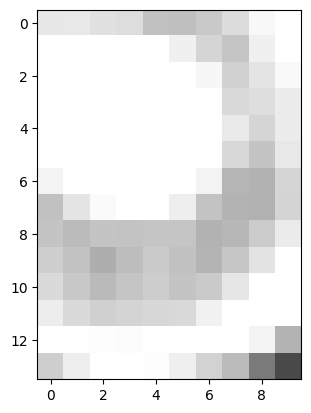

In [57]:
# Visualisons la zone d'intérêt d'une image
y_start, y_end = int(taille_image[0]*COEF_Y1), int(taille_image[0]*COEF_Y2)
x_start, x_end = int(taille_image[1]*COEF_X1), int(taille_image[1]*COEF_X2)
img_cropped = img[y_start:y_end, x_start:x_end]
plt.imshow(img_cropped)

In [58]:
# Fonction de découpage de la zone d'intérêt d'une image
def preparation_image(dir_source, dir_crop):
    
    for img in glob.glob(os.path.join(dir_source, '**', f"{PREFIX}*{SUFFIX}*.bmp"), recursive=True):        
        # Load the image
        image_path = img #os.path.join(dir_source, img)
        #+ r"/input/"         
        image = cv2.imread(image_path)

        # Crop the window
        cropped_image = image[y_start:y_end, x_start:x_end]
        
        # Resize image
        cropped_image = cv2.resize(cropped_image, (256, 256))

        # Créer le dossier s'il n'existe pas
        dossier = dir_crop 
        os.makedirs(dossier, exist_ok=True)
        
        # Chemin d'accès pour sauvegarder l'image préparée
        cropped_image_path = os.path.join(dossier, os.path.basename(img))
        # assert cropped_image_path est le chemin d'une image dans le dossier de sortie

        # Sauvegarder l'image au même nom que l'image d'origine
        cv2.imwrite(cropped_image_path, cropped_image)

In [59]:
# Création d'un dossier de stockage des zones d'intérêt des images
DATA_CROP = "DATA_CROP/crop"
preparation_image(DATA, DATA_CROP)
assert os.path.exists(DATA_CROP)==True, print(f"pas d\'image {PREFIX}{SUFFIX} dans {DATA}")

In [60]:
# Inférence
datagen_test = ImageDataGenerator(rescale=1./255,
                               height_shift_range=False,
                               horizontal_flip=False,
                               validation_split=0,
                               preprocessing_function=preprocess_input)

test_generator = datagen_test.flow_from_directory(
    "DATA_CROP",
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    subset=None
)

Found 946 images belonging to 1 classes.


In [61]:
%%time
#35s pour 7000 images

# Créer un générateur d'images pour la prédiction
predict_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

# Spécifiez le répertoire contenant le répertoire contenant les images pour la prédiction
PREDICT_DIR = "DATA_CROP"

predict_generator = predict_datagen.flow_from_directory(
    PREDICT_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

# Faire les prédictions
predictions = MODEL.predict(predict_generator, steps=len(predict_generator), verbose=1)

# Récupérer les noms de fichiers pour lier les prédictions aux images
filenames = predict_generator.filenames

# Associer chaque fichier d'image à sa prédiction
liste_defaut = []
for filename, prediction in zip(filenames, predictions):
    predicted_class = np.argmax(prediction)
    if predicted_class == 1:
        print(f"Image: {filename} - Prediction: {predicted_class}")
        liste_defaut.append(filename)
print(f"Found {len(liste_defaut)} defects")

Found 946 images belonging to 1 classes.
946/946 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Image: crop/LH_39773_07_NG.bmp - Prediction: 1
Image: crop/LH_39822_07_NG.bmp - Prediction: 1
Image: crop/LH_39869_07_NG.bmp - Prediction: 1
Image: crop/LH_42557_07_NG.bmp - Prediction: 1
Image: crop/LH_44285_07_NG.bmp - Prediction: 1
Image: crop/LH_44421_07_NG.bmp - Prediction: 1
Image: crop/LH_44534_07_NG.bmp - Prediction: 1
found 7 defects
CPU times: user 4.84 s, sys: 377 ms, total: 5.22 s
Wall time: 5.2 s


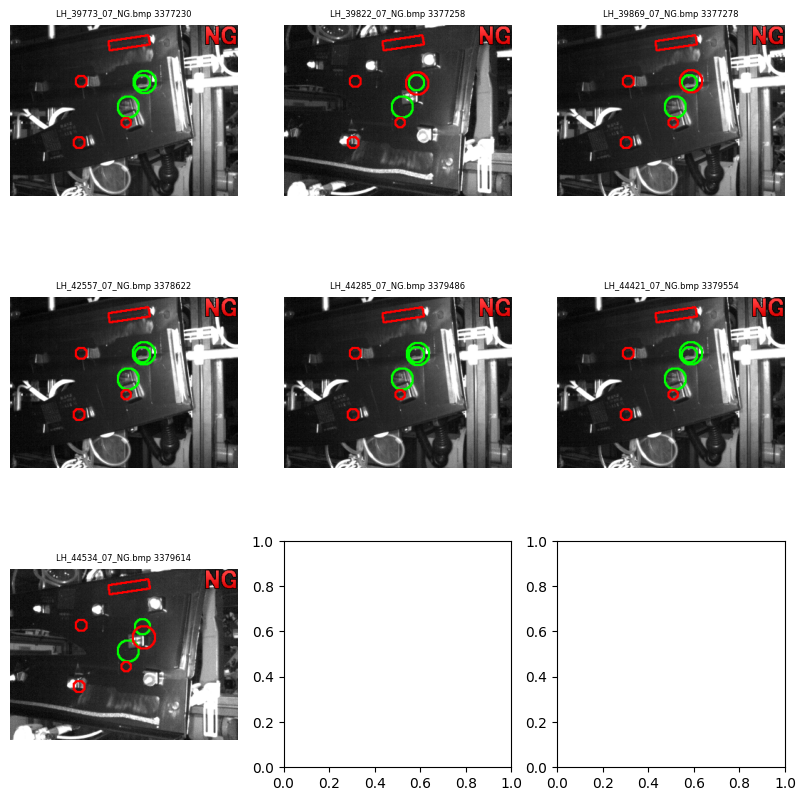

In [66]:
# Visualisation des défauts
fig, ax = plt.subplots(1+len(liste_defaut[0:9])//3, 3, figsize=(10,10))
ax = ax.flatten()
for idx, filename in enumerate(liste_defaut[0:9]) : 
    filename_tot = glob.glob(os.path.join(
        #PREDICT_DIR,
        DATA,
        '**', 
        os.path.basename(filename)), 
                             recursive=True)[0]
    #assert filename_tot existe
    ax[idx].imshow(plt.imread(filename_tot))
    #date_creation = time.ctime(os.path.getmtime(filename_tot))
    
    part_num = glob.glob(os.path.join(DATA, '**', os.path.basename(filename_tot)), recursive=True)[0]
    num_piece = os.path.dirname(part_num)[-7:]
    
    ax[idx].set_title(f"{os.path.basename(filename_tot)} {num_piece}",fontsize=6)
    ax[idx].axis('off')

In [63]:
# Exporter la liste des images NC
export = pd.DataFrame({NOM_DEFAUT:liste_defaut})
export.to_csv("resultat.csv", index=False)